<a href="https://colab.research.google.com/github/NikithaLakshmiJ/mbti-personality-predictor/blob/main/mbti_personality_predictor_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data Analysis
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine Learning packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.cluster as cluster
from sklearn.manifold import TSNE

# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#loading dataset
data_set = pd.read_csv("mbti_1.csv")
data_set.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


# **Exploratory data analysis**

    1.List item
    2.List item

Checking if there are any missing or null values present in the dataset.

In [ ]:
data_set.isnull().any()

type     False
posts    False
dtype: bool

In [ ]:
nRow, nCol = data_set.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 8675 rows and 2 columns


Dataset Information

In [ ]:
data_set.dtypes

type     object
posts    object
dtype: object

In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [ ]:
data_set.describe(include=['object'])

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


*   There are 16 unique personality type indicators in the dataset
*   INFP is the most frequently occuring personality type in our dataset

 (no. of occurences is 1832)
*   Lastly, there are no repeating posts in the dataset

Now we finding the unique values from the 'type' of personality column

In [ ]:
types = np.unique(np.array(data_set['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [ ]:
total = data_set.groupby(['type']).count()*50
total

,posts
type,
ENFJ,9500
ENFP,33750
ENTJ,11550
ENTP,34250
ESFJ,2100
ESFP,2400
ESTJ,1950
ESTP,4450
INFJ,73500


Group by allows you to split your data into separate groups to perform computations for better analysis.

Data visualization for no. of posts for each personality type

Text(0.5, 1.0, 'Total posts for each personality type')

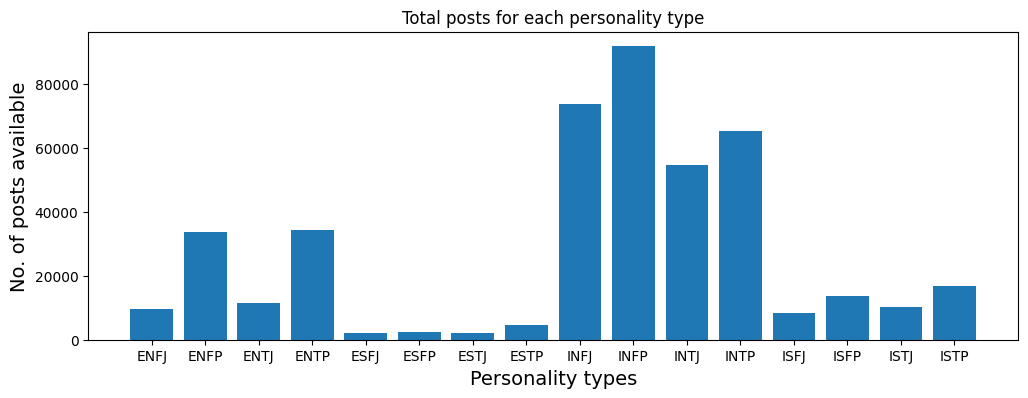

In [ ]:
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

The dataset is clearly unbalanced throughout the different classes. We observe that some of the personality types has a lot more data than others, the most common Kaggle users personality is INFP (Introvert Intuition Feeling Perceiving).

However, we reach this conclusion based on user comments: we can consider for now that users who comment on social media more frequently are more intoverted, perceptive, and emotional. 

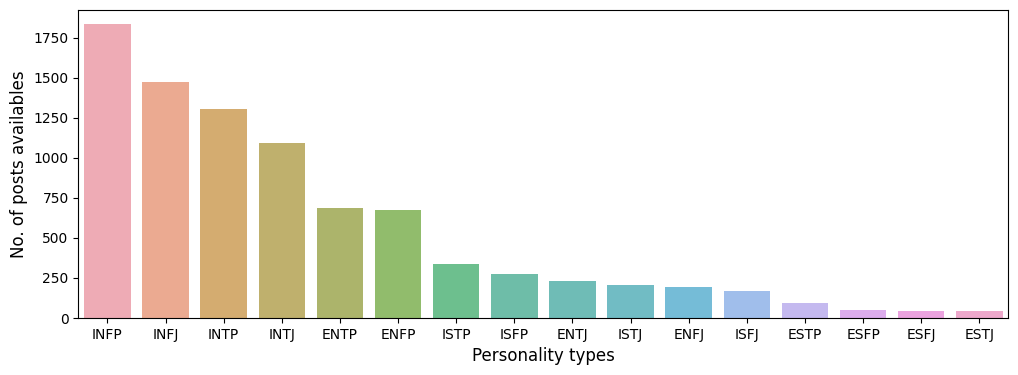

In [ ]:
#Plotting this in descending order for better understanding of this visualization
cnt_srs = data_set['type'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_srs.index,y=cnt_srs.values, alpha=0.8)
plt.xlabel('Personality types', fontsize=12)
plt.ylabel('No. of posts availables', fontsize=12)
plt.show()

Since the original dataset only came with 2 features, the Type and 50 posts for each person, we decided to create additional features for exploring & analysing our dataset.

After we added our features, we did some data exploration to see how the raw data looks and to see how important our features were for distinguishing types across the MBTI personalities. Below are plots further showing the type imbalances in our data.

SWARM PLOT :

Swarm Plots, also called beeswarm plots, they plot all of the data points

<Axes: xlabel='type', ylabel='words_per_comment'>

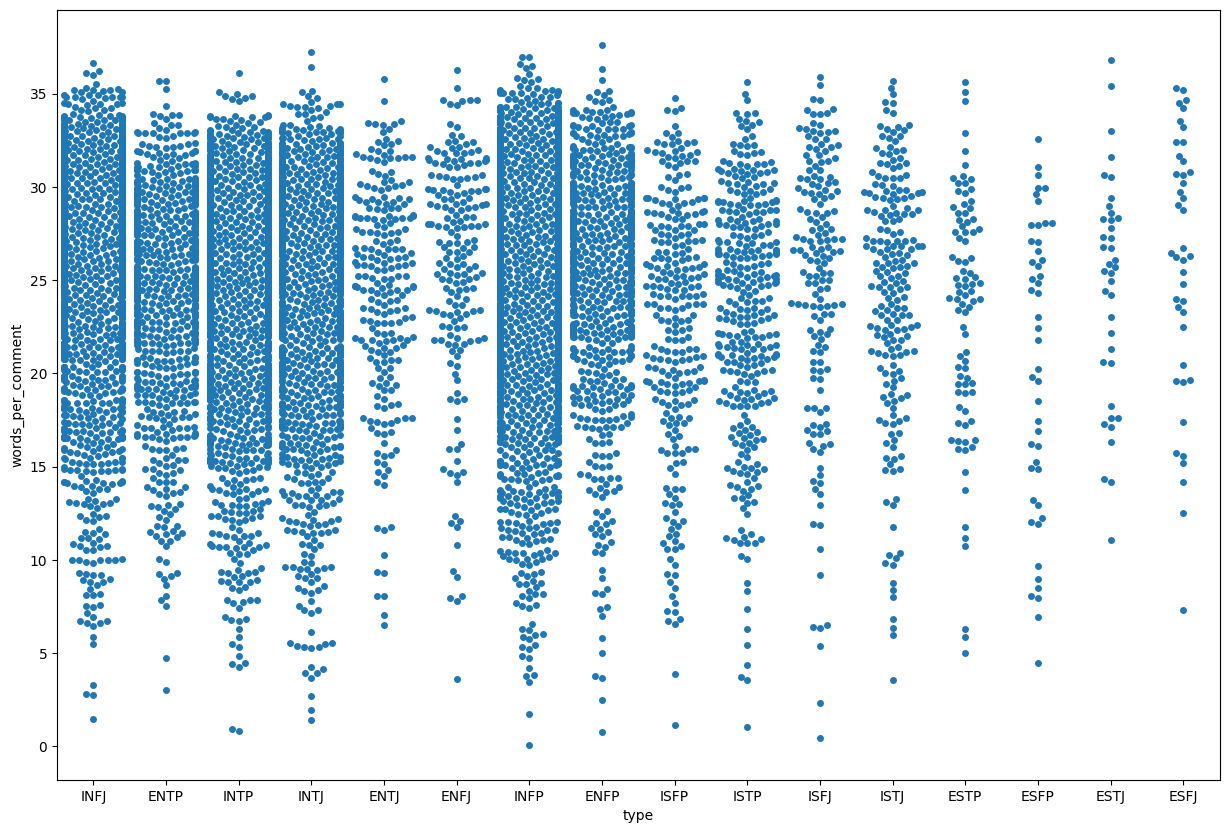

In [ ]:
df = data_set.copy()
#this function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))

plt.figure(figsize=(15,10))
sns.swarmplot(x="type", y="words_per_comment", data=df)

This plot further shows clearly that there are a no. of imbalances in our dataset, showing all the observations along with some representation of the underlying distribution using our added features.

INFP has the most cluttered showing there are most no. of comments of this type of personality

**JOINT PLOT**

Plotting the joint plot between the no. of words that occur in each comment v/s 
their variance

Jointplot is seaborn library specific and can be used to quickly visualize and analyze the relationship between two variables and describe their individual distributions on the same plot. 

A distribution plot at the top for the column on the x-axis, a distribution plot on the right for the column on the y-axis and a scatter plot in between that shows the mutual distribution of data for both the columns. The area below the histogram helps in calculating the PDF, i.e. Probability Density function and the highest peak of the curve is the mean of distribution.

<Figure size 1500x1000 with 0 Axes>

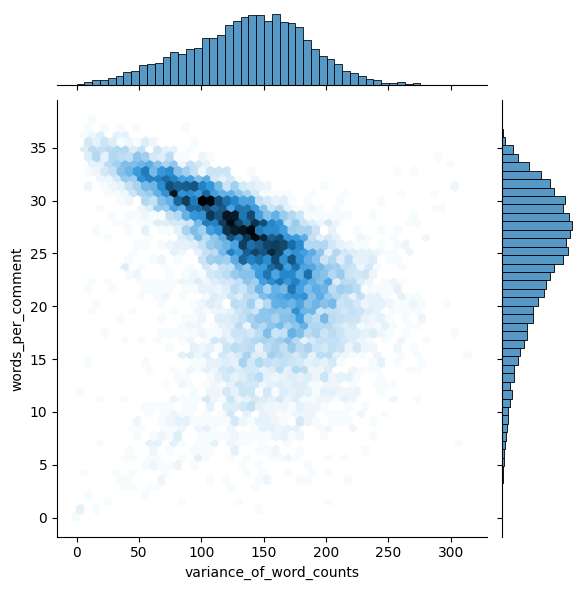

In [ ]:
plt.figure(figsize=(15,10))
sns.jointplot(x="variance_of_word_counts", y="words_per_comment", data=df, kind="hex")

*   The 2 histogram plots represent Gaussian distribution of a sample space, which in our case comprises of no. of words per comment and associated variance of word counts from our dataset.
*   In the hexagonal plot, the hexagon with most number of points gets **darker color**. So if you look at the above plot, you can see that most of the posts have words between 100 and 150 and most of no. of words per comment by a user is between 25-30.
*   We can see that there is no correlation observed between variance of word count and the words per comment.
*   There is a strong relationship when there are 25-30 words per comment & the variance of word counts is 100-150
*   This is also visible by analyzing the histogram plots on both the axis.

Now we see the Joint Plots for each Personality Type

<Figure size 2400x500 with 0 Axes>

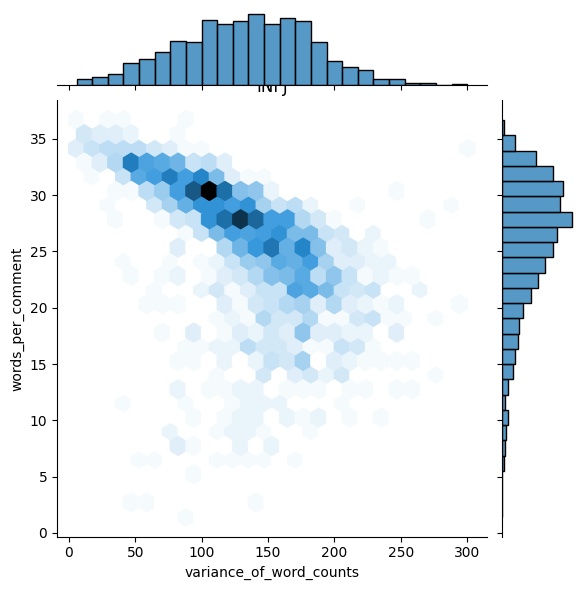

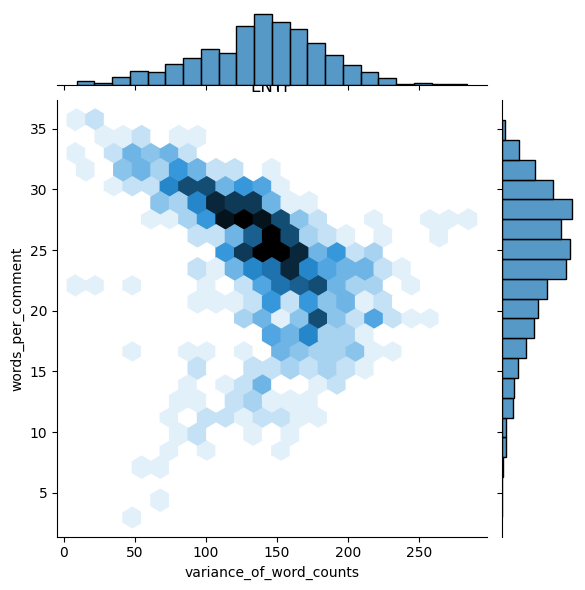

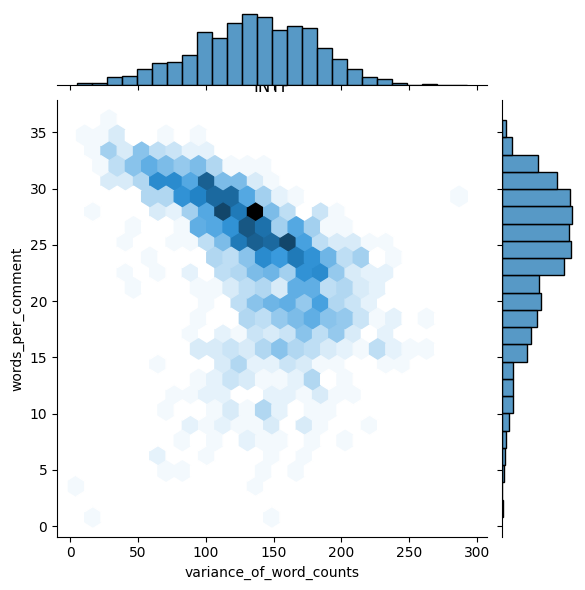

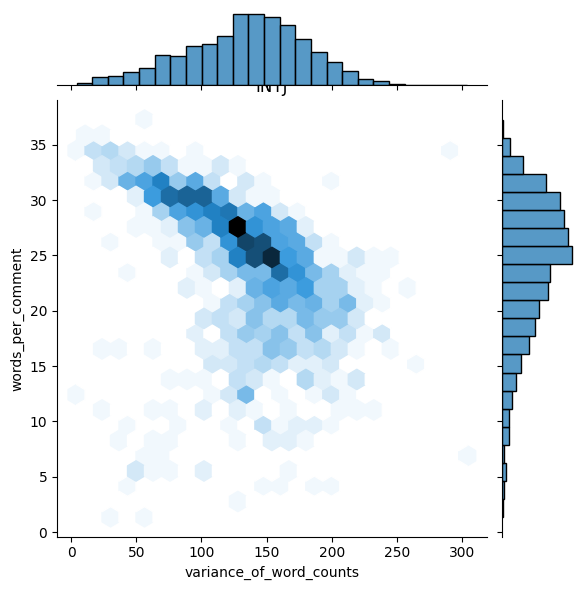

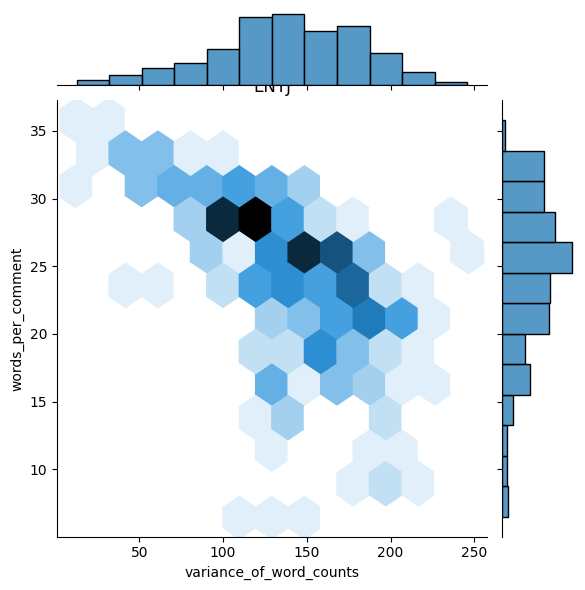

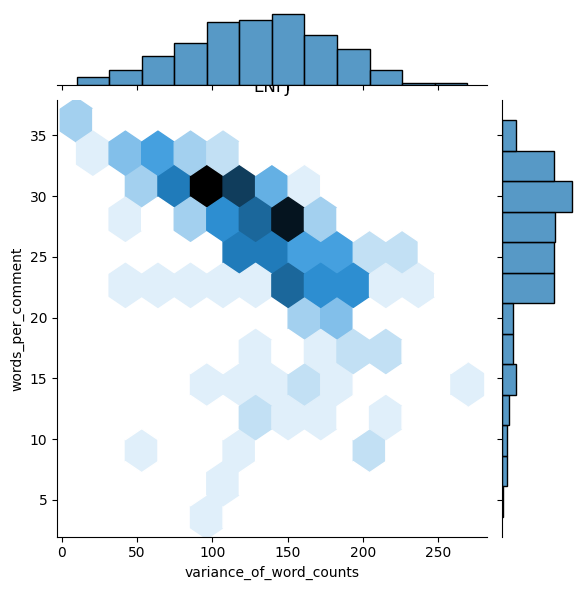

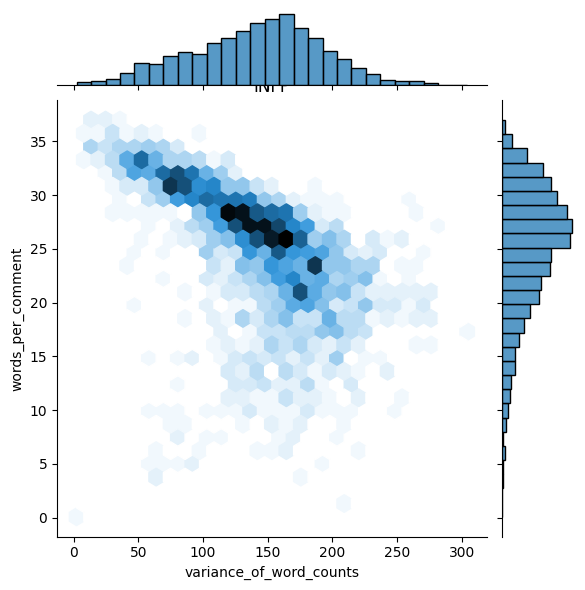

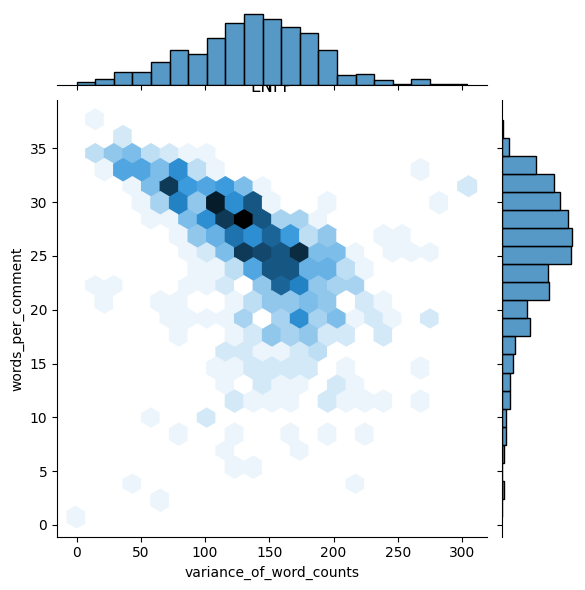

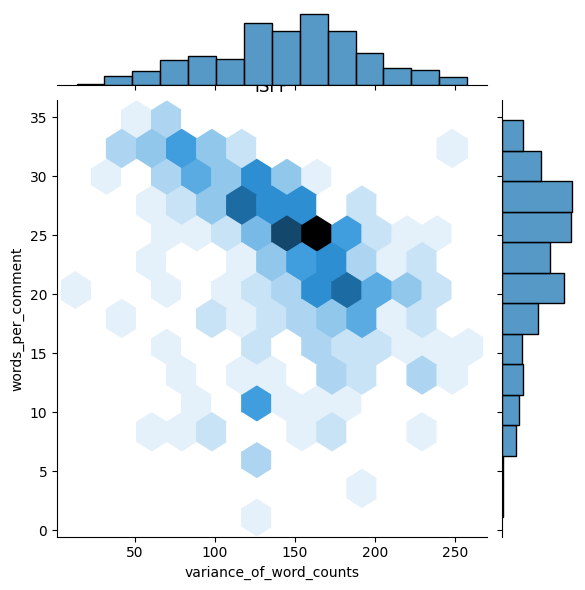

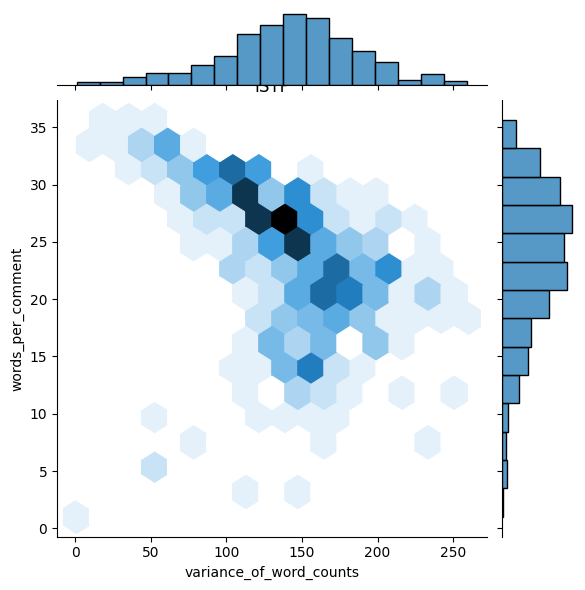

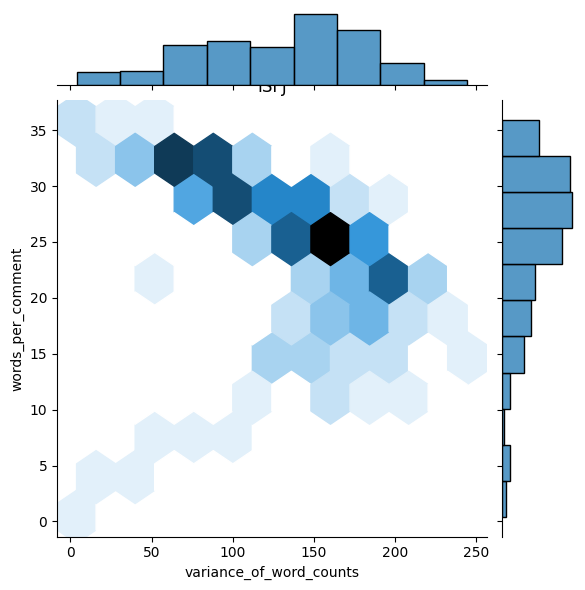

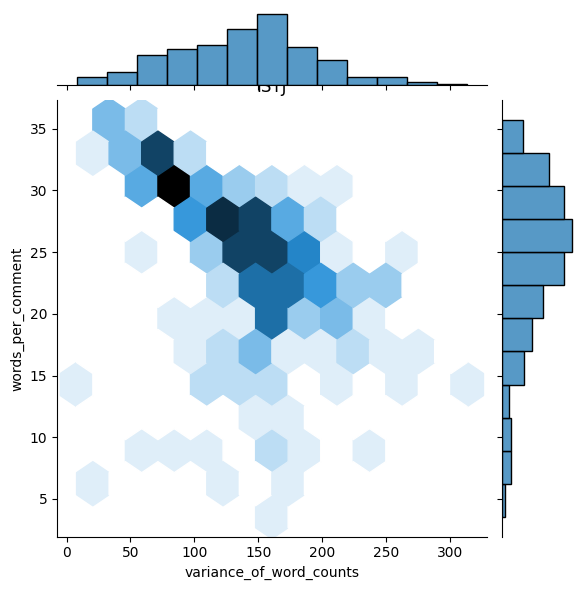

In [ ]:
def plot_jointplot(mbti_type, axs, titles):
    df_1 = df[df['type'] == mbti_type]
    sns.jointplot("variance_of_word_counts", "words_per_comment", data=df_1, kind="hex", ax = axs, title = titles)

plt.figure(figsize=(24, 5))    
i = df['type'].unique()
k = 0

for m in range(1,3):
  for n in range(1,7):
    df_1 = df[df['type'] == i[k]]
    sns.jointplot(x="variance_of_word_counts",y= "words_per_comment", data=df_1, kind="hex" )
    plt.title(i[k])
    k+=1
plt.show()



*   For all the plots you can see that most of the posts have words btw 100-150 and most of no. of words per comment by a user is nearly 25 to 30 range.
*   Exception to this case is for the plots for ISPJ and ISTJ, but this maybe due to the fact that there are significantly less no. of posts available for these personality types (further shown by the bar plots below)

*   We can see that there is no correlation observed between variance of word count and the words per comment.
*   But there is a weak negative correlation observed between the 2 features for few personalities. Maybe this could be due to the low no. of posts available for that type in the given Kaggle dataset.
*   No useful inferences can be made by analyzing the individual jointplots as the total no of posts for each personlaity type is different.

Hence, these features will not be useful in building our Personality prediction model.



**DISTANCE PLOT:**

This seaborn visualization method shows the histogram distribution of data for a single column.

Text(0.5, 1.0, 'Distribution of Lengths of all 50 Posts')

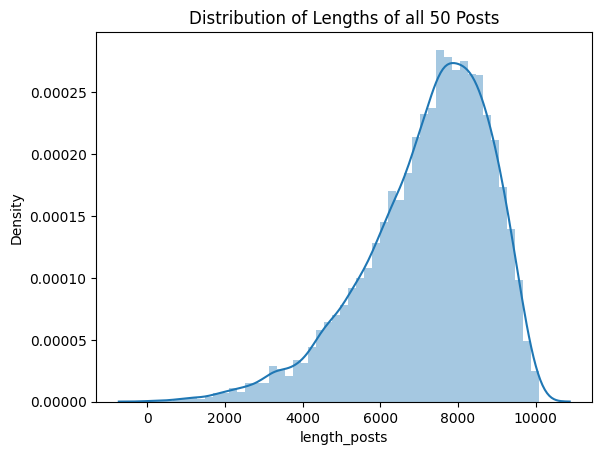

In [ ]:
df["length_posts"] = df["posts"].apply(len)
sns.distplot(df["length_posts"]).set_title("Distribution of Lengths of all 50 Posts")



*   We can see that most no of lengthly posts have between 7000-9000 words.
*  The line that you see represents the kernel density estimation. It is a fundamental data smoothing problem where inferences about the population, based on a finite data sample. This kernel density estimate is a function defined as the sum of a kernel function on every data point.



In [ ]:
#Finding the most common words in all posts.
words = list(df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(40)

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496),
 ('an', 59020),
 ("I'm", 57339),
 ('on', 57062),
 ('was', 56146),
 ('me', 55488),
 ('as', 53310),
 ('this', 52601),
 ('just', 48292),
 ('about', 46305),
 ('think', 46229),
 ('or', 45724),
 ("don't", 44821),
 ('so', 42935),
 ('your', 40918),
 ('do', 40867),
 ('what', 37746),
 ('at', 37566),
 ('can', 37535),
 ('if', 37042),
 ('people', 35546)]

**WORDCLOUD**

WordCloud is a technique to show which words are the most frequent among the given text. 

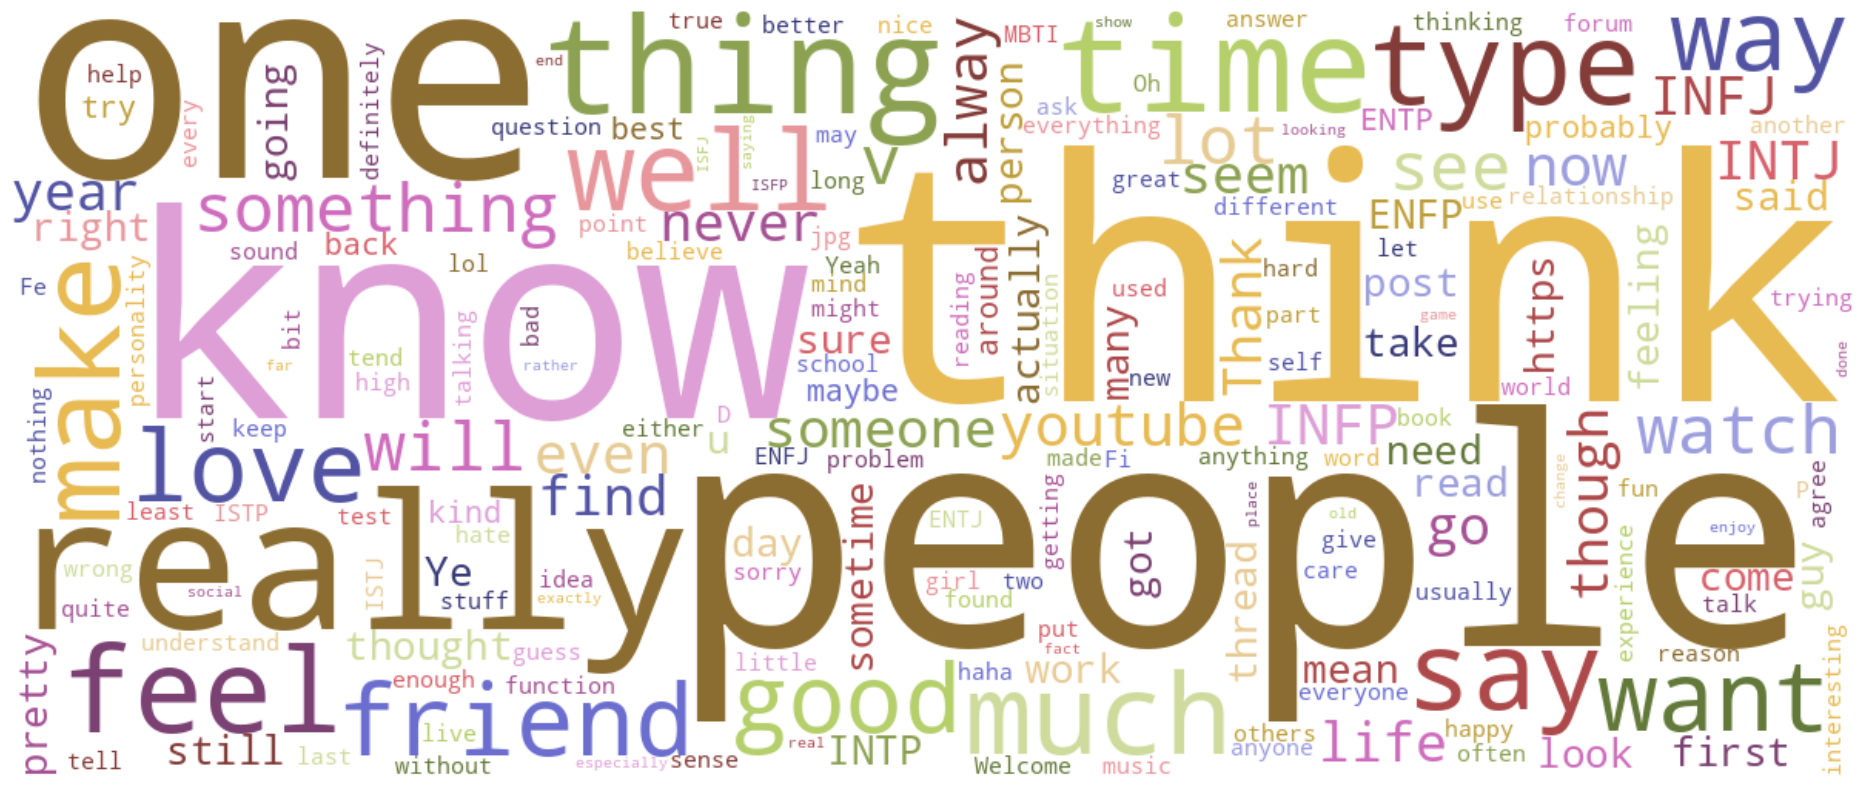

In [ ]:
#Plotting the most common words with WordCloud.
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))

# collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
plt.figure(figsize=(25,10))
# generate word cloud, interpolation 
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

Now we see the Wordclouds for each Personality Type. We produced 16 Word Clouds for 16 groups of personality. These word clouds are generated such that the size of each word is proportional to its appearance frequency in the top posts. We consider these word clouds to be illustrative of some of the unique ways that different MBTIs use language.

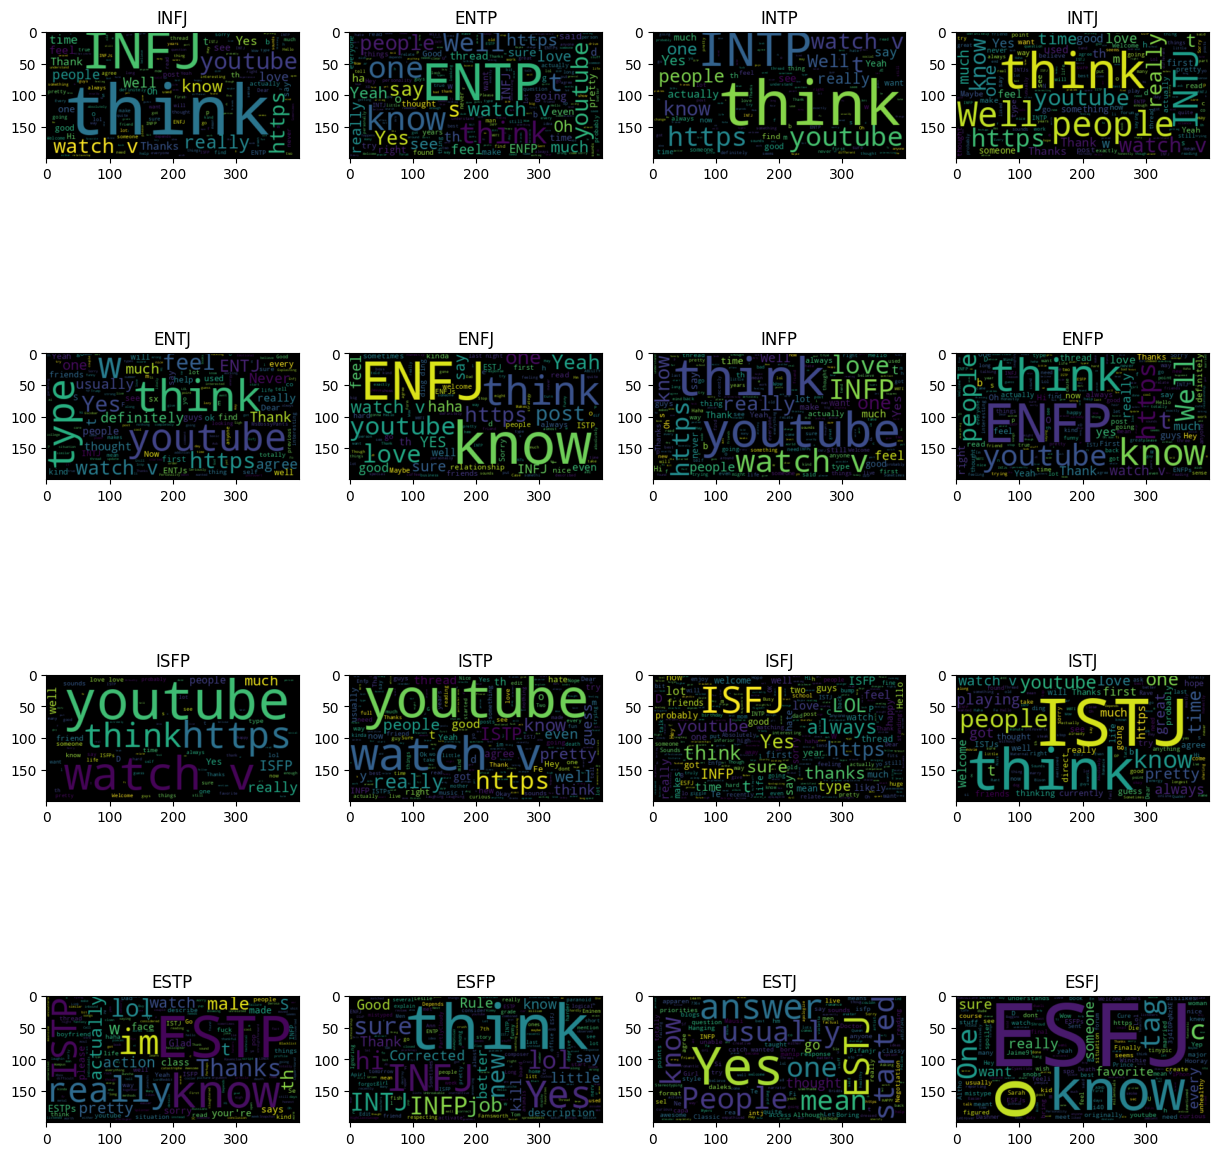

In [ ]:
fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(15,len(df['type'].unique())))
k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

*  we can see there are a no. of irrelevant words present in the dataset (e.g. ha, ar, Ti etx.) which will need to be removed
*  Interestingly, among the most common words in the word clouds of individual personality types, is the names of MBTI personlity types themselves.

It would hence be necessary to clean our posts by removing these MBTI words from each of them as part of our pre-processing stage, before training the model for better evaluation results.

In [ ]:
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
df.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(df))
print("Number of posts", len(posts))
print("5 posts from start are:")
posts[0:5]

Number of users 8675
Number of posts 422845
5 posts from start are:


[('INFJ', "'http://www.youtube.com/watch?v=qsXHcwe3krw"),
 ('INFJ', 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg'),
 ('INFJ',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'),
 ('INFJ', 'What has been the most life-changing experience in your life?'),
 ('INFJ',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.')]



*   It is inferenced that a lot of hyperlinks are presnt in these posts
*   It is safe to assume that url links do not provide any real information about a user's personality, hence, we need to clean our dataset for these too.

This given sample dataset does not come from the entire Kaggle user population; rather, it comes from Kaggle users who leave comments; thus, our ML model's conclusion cannot be applied to all Kaggle users, only to those who leave comments. 

Furthermore, with more data, more accurate models could be obtained. As a result, the model may fail to classify a personality at the lower end.





# Pre-Processing Stage
**NOTE**: this phase might take some time to execute due to computationaly expensive operations

In [ ]:
def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()

    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
    
    return df

#Preprocessing of entered Text
new_df = preprocess_text(data_set)

In [ ]:
#Remove posts with less than X words
min_words = 15
print("Before : Number of posts", len(new_df)) 
new_df["no. of. words"] = new_df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))

Before : Number of posts 8675
After : Number of posts 8466


# Feature Engineering 

In [ ]:
new_df.head()

,type,posts,no. of. words
0,INFJ,enfp intj moments sportscenter plays...,430
1,ENTP,finding lack these posts very alarming eo...,803
2,INTP,good course which know thats bles...,253
3,INTJ,dear intp enjoyed conversation other eos...,777
4,ENTJ,youre fired eostokendot thats another silly...,402


## Splitting into X and Y feature

**1.  LabelEncoder** : Provided by Sklearn library that converts the the levels of categorical features (labels) into numeric form so as to convert it into the machine-readable form. It encode labels with a value between 0 and n_classes-1 where n is the number of distinct labels. If a label repeats it assigns the same value to as assigned earlier. 


In [ ]:
# Converting MBTI personality (or target or Y feature) into numerical form using Label Encoding
# encoding personality type
enc = LabelEncoder()
new_df['type of encoding'] = enc.fit_transform(new_df['type'])

target = new_df['type of encoding'] 

In [ ]:
new_df.head(15)

,type,posts,no. of. words,type of encoding
0,INFJ,enfp intj moments sportscenter plays...,430,8
1,ENTP,finding lack these posts very alarming eo...,803,3
2,INTP,good course which know thats bles...,253,11
3,INTJ,dear intp enjoyed conversation other eos...,777,10
4,ENTJ,youre fired eostokendot thats another silly...,402,2
5,INTJ,eostokendot science perfect eostokendo...,245,10
6,INFJ,cant draw nails haha eostokendot those w...,970,8
7,INTJ,tend build collection things desktop th...,140,10
8,INFJ,sure thats good question eostokendot dist...,522,8
9,INTP,this position where have actually pe...,130,11




*   We choose label encoding over one-hot encoding to reduce the pre-processing time, and majority due to the fact that there are predefined 16 values under MBTI and assigning unique integer based on alphabetical ordering seems like a viable option
*   It seems like a better option to the curse of dimensionality in the feature space.



In natural language processing, useless words are referred to as **stop words**. 

In [ ]:
# The python natural language toolkit library provides a list of english stop words.
import nltk
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.




*   We observe that almost all of these were were the most occuring words in our wordcloud above



**2.  CountVectorizer** is used to convert a collection of text documents to a vector of term/token counts and build a vocabulary of known words, but also to encode new documents using that vocabulary. It also enables the pre-processing of text data prior to generating the vector representation. 

Here, we use **stop_words='english'** with CountVectorizer since this just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. This is an important step in pre-processing as our model can often be improved if you don’t take those words into account. 


In [ ]:
# Vectorizing the posts for the model and filtering Stop-words
vect = CountVectorizer(stop_words='english') 

# Converting posts (or training or X feature) into numerical form by count vectorization
train =  vect.fit_transform(new_df["posts"])

In [ ]:
train.shape

(8466, 98555)



*   So now there are 98555 features in our dataset for 8466 rows (users)



---
Now we train the model in multiple ML algorithms namely: Random Forest, XGBoost, Gradient Descent, Support Vector Machine,  in order to choose the classifier which shows the best accuracy results. 

Additionaly, we split the dataset into testing and training in multiple ratios to find out which gives the best results. 

# Training & Evaluating : 60-40 split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(5079, 98555) (5079,) (3387, 98555) (3387,)


**Note:** Algorithms below can be quite time consuming

In [ ]:
accuracies = {}

#Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

# make predictions for test data
Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.53%


In [ ]:
#Gradient Descent
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)

Y_pred = sgd.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Gradient Descent'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 38.41%


Accuracy: 16.45%


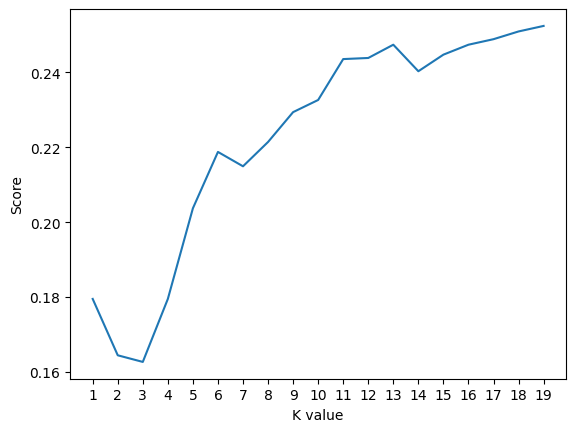

Maximum KNN Score is 25.24%


In [ ]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['KNN'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#try to find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100

print("Maximum KNN Score is {:.2f}%".format(acc))

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train, y_train)

Y_pred = svm.predict(X_test)

predictions = [round(value) for value in Y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['SVM'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 35.52%


## Comparing Algorithms

In [ ]:
pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracies(%)'])

,Accuracies(%)
Random Forest,39.533510
Gradient Descent,38.411574
KNN,16.445232
SVM,35.518158


We can clearly see that this model underfits out dataset when we apply split ratio of 60:40 on our dataset i.e. the model has  not learned enough from the training data, resulting in low generalization and unreliable predictions. (almost all the results are near 50%, which is not good)

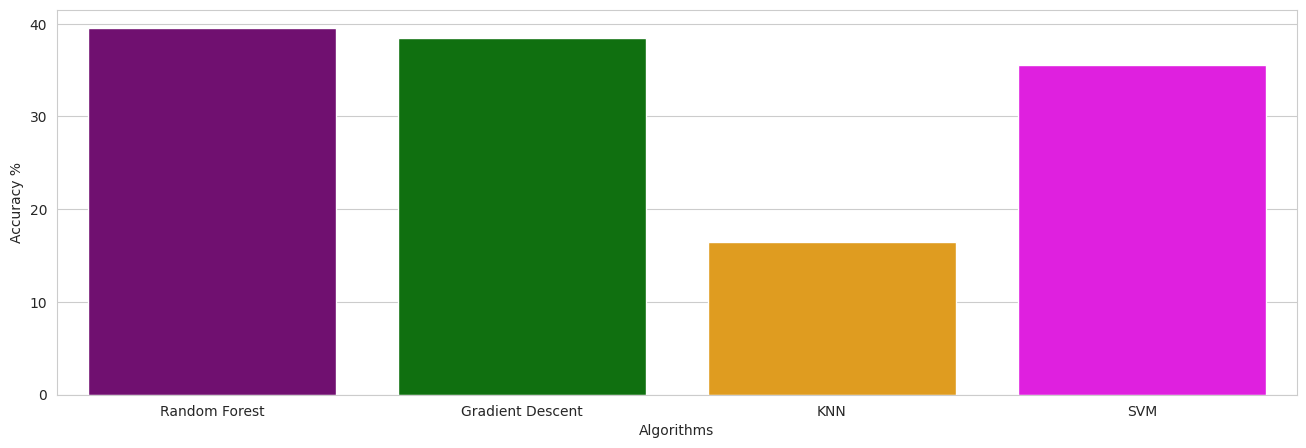

In [ ]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

# Training & Evaluating : 70-30 split

In [ ]:
accuracies = {}

#Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

# make predictions for test data
Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.53%


In [ ]:
#XG boost Classifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

Y_pred = xgb.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['XG Boost'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.87%


In [ ]:
#Gradient Descent
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)

Y_pred = sgd.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Gradient Descent'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 41.69%


In [ ]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Logistic Regression'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.37%


Accuracy: 16.45%


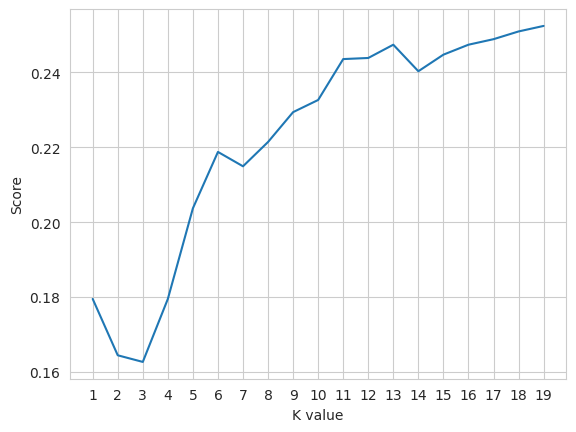

Maximum KNN Score is 25.24%


In [ ]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['KNN'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#try to find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100

print("Maximum KNN Score is {:.2f}%".format(acc))

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train, y_train)

Y_pred = svm.predict(X_test)

predictions = [round(value) for value in Y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['SVM'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 35.52%


## Comparing Algorithms

In [ ]:
pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracies(%)'])

,Accuracies(%)
Random Forest,39.533510
XG Boost,57.868320
Gradient Descent,41.688810
Logistic Regression,58.370239
KNN,16.445232
SVM,35.518158


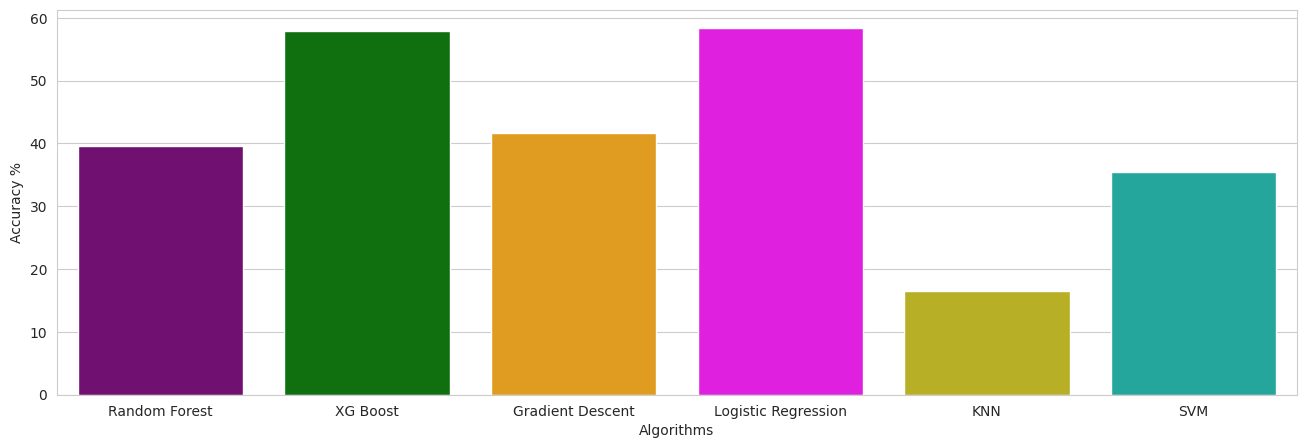

In [ ]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

Inference : test_size=0.3 gives marginally better results for all algorithms


As we can the above ML classifiers performs at efficieny of nearly 50% only - which is pretty bad. So, instead of selecting all 16 types of personalities as a unique feature, we hence train 4 classifiers individually to classify their personalities based on MBTI type.



---



The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into **16 distinct personality types across 4 axis**:

- Introversion (I) – Extroversion (E)
- Intuition (N) – Sensing (S)
- Thinking (T) – Feeling (F)
- Judging (J) – Perceiving (P)


# Four Classifiers across MBTI axis

In [ ]:
data = pd.read_csv("mbti_1.csv")
data

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


Now we add columns for personality type indicators



In [ ]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


*   Using the above code, if a person has I, N, T and J, the value across the 4 axis of MBTI i.e. IE, NS, TF and JP respectively, will be 1. Else 0. 

This will help us calculate for e.g. how many Introvert posts are present v/s how many Extrovert posts are presnt, out of all the given entries in our labelled Kaggle dataset. This is done in order to extplore the dataset for all the individual Personality Indices of MBTI  


**Counting** No. of posts in one class / Total no. of posts in the other class

In [ ]:
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) / Sensing (S):		 1197  /  7478
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


- We infer that there is **unequal distribution** even among each of the 4 axis in the entries of out dataset. i.e. out of IE:E is the majority, in NS:S is the majority. While TF and JP have realtively less differnce between them. 





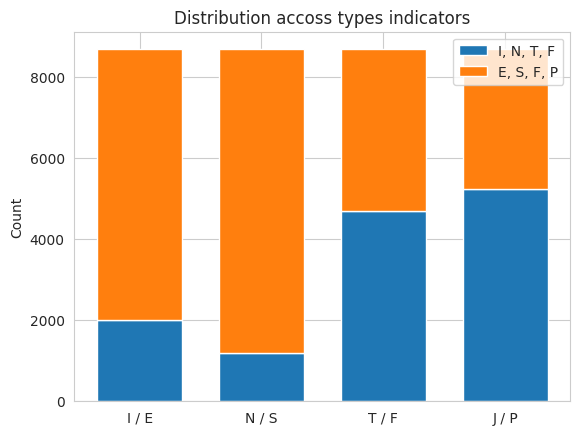

In [ ]:
#Plotting the distribution of each personality type indicator
N = 4
bottom = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.7           # or len(x) can also be used here

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()

*Fun Fact : The above results match with real life findings by researchers across various personality and psycological studies like*






We can compare this with the fact that **Introverts** are a minority, making up roughly 16 percent of people [[1]](https://celesteheadlee.medium.com/congratulations-youre-probably-not-an-introvert-8bcfcc918a18#:~:text=Even%20among%20introverts%2C%20though%2C%20there,innate%20needs%20for%20Homo%20sapiens.). Eventhough among introverts, there are varying degrees, and Carl Jung said, “There is no such thing as a pure **Extrovert** or a pure introvert" Hence it is tricky to classify a person with 1 type. 

While the population is split roughly 50/50 on the other dimensions, a full 70% of people show a preference for **Sensing** over **Intuition** when taking a personality test. Because Intuitives are the minority, the onus is on them to adjust to the Sensor way of thinking.

The differences between **Judging** and **Perceiving** are probably the most marked differences of all the four preferences. People with strong Judging preferences might have a hard time accepting people with strong Perceiving preferences, and vice-versa. On the other hand, a "mixed" couple (one Perceiving and one Judging) can complement each other very well, if they have developed themselves enough to be able to accept each other's differences.

**Features Correlation Analysis**

In [ ]:
data[['IE','NS','TF','JP']].corr()

,IE,NS,TF,JP
IE,1.000000,-0.045899,-0.069573,0.161939
NS,-0.045899,1.000000,-0.080954,0.014922
TF,-0.069573,-0.080954,1.000000,-0.004673
JP,0.161939,0.014922,-0.004673,1.000000


- It is unclear if the matrix shows anything valuable for interpretation





An assumption made in our model is that each letter type is independent of other types i.e. A person’s introversion/extroversion is not related to their judgement/perception. Nevertheless, we want to still test them below using a heat map

<Axes: title={'center': 'Features Correlation Heatmap'}>

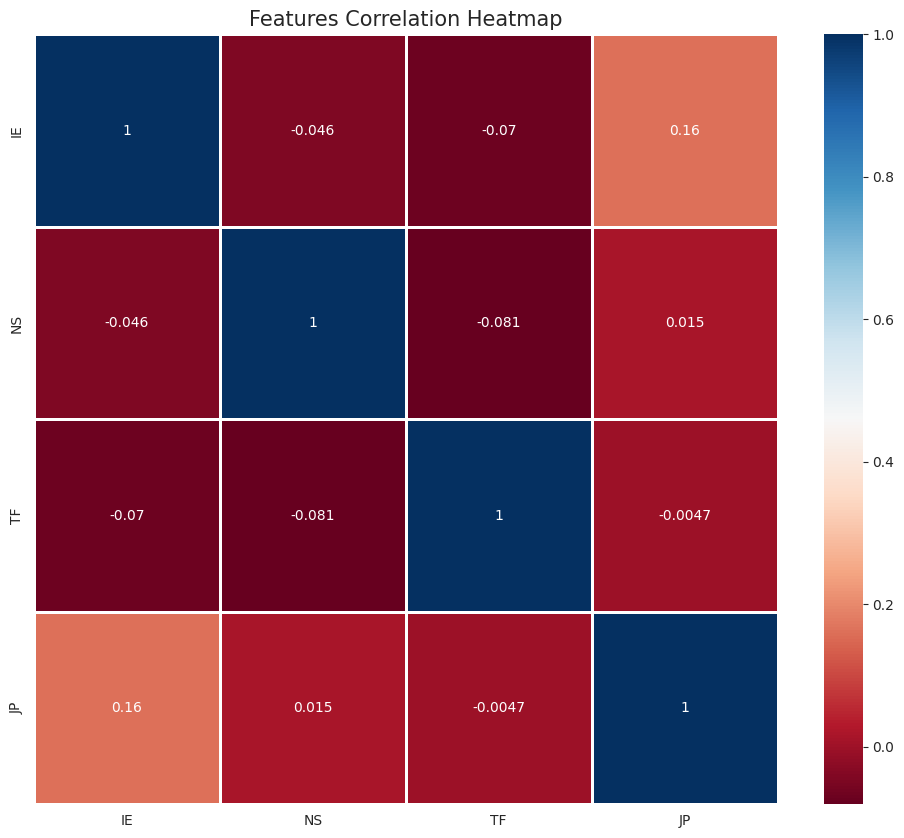

In [ ]:
cmap = plt.cm.RdBu
corr = data[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Features Correlation Heatmap', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

From this heatmap also, it is unclear if it shows anything valuable for interpretation

We preprocess the posts by using Lemmitization technique. **Lemmatization** is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words, hence we use this instead in our model. So it links words with similar meaning to one word. 

In [ ]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed 
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

# Or we can use Label Encoding (as above) of this unique personality type indicator list
# from sklearn.preprocessing import LabelEncoder
# unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
#        'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
# lab_encoder = LabelEncoder().fit(unique_type_list)

Binarizing the each personality type feature

In [ ]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [b_Pers[l] for l in personality]

#To show result output for personality prediction
def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


Cleaning of data in the posts

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_data = len(data)
  i=0
  
  for row in data.iterrows():
      # check code working 
      # i+=1
      # if (i % 500 == 0 or i == 1 or i == len_data):
      #     print("%s of %s rows" % (i, len_data))

      #Remove and clean comments
      posts = row[1].posts

      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

In [ ]:
nRow, nCol = list_personality.shape
print(f'No. of posts = {nRow}  and No. of Personalities = {nCol} ')

No. of posts = 8675  and No. of Personalities = 4 


## Feature Engineering


**Tf–idf** for feature engineering evaluates how relevant/important a word is to a document in a collection of documnets or corpus. As we train individual classifiers here, it is very useful for scoring words in machine learning algorithms for Natural Language Processing. 

For our model we vectorize using count vectorizer and tf-idf vectorizer keeping the words appearing btw 10% to 70% of the posts.

In [ ]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1000,  
                             max_df=0.7,
                             min_df=0.1) 
# the feature should be made of word n-gram 
# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'act'), (5, 'action'), (6, 'actually'), (7, 'add'), (8, 'advice'), (9, 'afraid')]

Using Tf-idf :
Now the dataset size is as below
(8675, 595)


- Therefore we now have 595 features for each user post.

#counting top 10 words
reverse_dic = {}
for key in cntizer.vocabulary_:
    reverse_dic[cntizer.vocabulary_[key]] = key
top_10 = np.asarray(np.argsort(np.sum(X_cnt, axis=0))[0,-10:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_50]

- We have successfully removed all irrelevant words 

Hence we split the features as :

X: User Posts in TF-IDF representation

Y: Personality type in Binarized MBTI form

In [ ]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


Let's see how the posts look in TF-IDF representation: (we have taken 1st post for demonstration)

In [ ]:
print("X: 1st posts in tf-idf representation\n%s" % X_tfidf[0])

X: 1st posts in tf-idf representation
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.08105478 0.07066064
 0.         0.         0.         0.         0.         0.
 0.         0.04516864 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05321691 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0871647  0.         0.         0.
 0.         0.         0.         0.05506308 0.0708757  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16585935 0.         0.         0.09676192 0.
 0.         0.04970682 0.         0.         0.         0.
 0.07397056 0.         0.         0.         0.         0.
 0.       

Let's see how the posts look in Binarized MBTI personality indicator representation: (we have taken 1st post for demonstration)



In [ ]:
print("For MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[0,:])

For MBTI personality type : INFJ
Y : Binarized MBTI 1st row: [0 0 0 0]


Therefore we have successfully converted the textual data into numerical form

## Training & Evaluating Models

In [ ]:
# Posts in tf-idf representation
X = X_tfidf

In [ ]:
#Random Forest model for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.54%
NS: Intuition (N) / Sensing (S) Accuracy: 86.03%
FT: Feeling (F) / Thinking (T) Accuracy: 66.47%
JP: Judging (J) / Perceiving (P) Accuracy: 62.84%


In [ ]:
#XGBoost model for MBTI dataset 
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 76.18%
NS: Intuition (N) / Sensing (S) Accuracy: 85.92%
FT: Feeling (F) / Thinking (T) Accuracy: 67.73%
JP: Judging (J) / Perceiving (P) Accuracy: 62.87%


In [ ]:
# Stocastic Gradient Descent for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = SGDClassifier() 
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 76.95%
NS: Intuition (N) / Sensing (S) Accuracy: 86.03%
FT: Feeling (F) / Thinking (T) Accuracy: 72.16%
JP: Judging (J) / Perceiving (P) Accuracy: 63.95%


In [ ]:
# Logistic Regression for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = LogisticRegression() 
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.54%
NS: Intuition (N) / Sensing (S) Accuracy: 86.06%
FT: Feeling (F) / Thinking (T) Accuracy: 72.44%
JP: Judging (J) / Perceiving (P) Accuracy: 64.51%


In [ ]:
#2 KNN model for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
   
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 76.67%
NS: Intuition (N) / Sensing (S) Accuracy: 85.82%
FT: Feeling (F) / Thinking (T) Accuracy: 54.70%
JP: Judging (J) / Perceiving (P) Accuracy: 40.20%


In [ ]:
# SVM model for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = SVC(random_state = 1)
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.96%
NS: Intuition (N) / Sensing (S) Accuracy: 86.03%
FT: Feeling (F) / Thinking (T) Accuracy: 72.62%
JP: Judging (J) / Perceiving (P) Accuracy: 65.87%


Out of all the models, seen above we see that on an average XG Boost gives relatively good performance, hence we choose it to build our Personality prediction model. This will be beneficial as XGBoost model [[2]](https://machinelearningmastery.com/xgboost-python-mini-course/) can even be used to evaluate and report on the performance on a test set for the model during training.


A number of configuration heuristics have been published in the original gradient boosting papers such as:

* learning_rate in XGBoost should be set to 0.1 or lower, and smaller values will require the addition of more trees.
* tree_depth in XGBoost should be configured in the range of 2-to-8, where not much benefit is seen with deeper trees.
and so on...

Here we have tried few parameters i order to improve our model's performance.

In [ ]:
# setup parameters for xgboost
param = {}

param['n_estimators'] = 200 #100
param['max_depth'] = 2 #3
param['nthread'] = 8 #1
param['learning_rate'] = 0.2 #0.1

# Individually training each mbti personlity type
for l in range(len(personality_type)):
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.37%
NS: Intuition (N) / Sensing (S) Accuracy: 85.85%
FT: Feeling (F) / Thinking (T) Accuracy: 70.28%
JP: Judging (J) / Perceiving (P) Accuracy: 64.37%


We find that these accuracies are improved than before. Hence we fine tune the hyperparameters XG boost and then train the Personalty detection model.

## Personality Prediction 1 - cover letter

In [ ]:
my_posts  = """ Hi I am 21 years, currently, I am pursuing my graduate degree in computer science and management (Mba Tech CS ), It is a 5-year dual degree.... My CGPA to date is 3.8/4.0 . I have a passion for teaching since childhood. Math has always been the subject of my interest in school. Also, my mother has been one of my biggest inspirations for me. She started her career as a teacher and now has her own education trust with preschools schools in Rural and Urban areas. During the period of lockdown, I dwelled in the field of blogging and content creation on Instagram.  to spread love positivity kindness . I hope I am able deliver my best to the platform and my optimistic attitude helps in the growth that is expected. Thank you for the opportunity. """

# The type is just a dummy so that the data prep function can be reused
mydata = pd.DataFrame(data={'type': ['INFJ'], 'posts': [my_posts]})

my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [ ]:
# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

#XGBoost model for MBTI dataset
result = []
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [ ]:
print("The result is: ", translate_back(result))

The result is:  INFJ


## Personality Prediction 2 - a poem

In [ ]:
my_posts = """ They act like they care They tell me to share But when I carve the stories on my arm The doctor just calls it self harm I’m not asking for attention There’s a reason I have apprehensions I just need you to see What has become of me||| I know I’m going crazy But they think my thoughts are just hazy When in that chaos, in that confusion I’m crying out for help, to escape my delusions||| Mental health is a state of mind How does one keep that up when assistance is denied All my failed attempts to fight the blaze You treat it like its a passing phase||| Well stop, its not, because mental illness is real Understand that we’re all not made of steel Because when you brush these issues under the carpet You make it seem like its our mistake we’re not guarded||| Don’t you realise that its a problem that needs to be addressed Starting at home, in our nest Why do you keep your mouths shut about such things Instead of caring for those with broken wings||| What use is this social stigma When mental illness is not even such an enigma Look around and you’ll see the numbers of the affected hiding under the covers ||| This is an issue that needs to be discussed Not looked down upon with disgust Mental illness needs to be accepted So that people can be protected ||| Let me give you some direction People need affection The darkness must be escaped Only then the lost can be saved||| Bring in a change Something not very strange The new year is here Its time to eradicate fear||| Recognise the wrists under the knives To stop mental illness from taking more lives Let’s break the convention Start ‘suicide prevention’.||| Hoping the festival of lights drives the darkness of mental illness away"""
mydata = pd.DataFrame(data={'type': ['INFP'], 'posts': [my_posts]})
my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)
my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [ ]:
# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

#XGBoost model for MBTI dataset
result = []
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [ ]:
print("The result is: ", translate_back(result))

The result is:  INTJ


## Pesonality Prediction 3 - short essay

In [ ]:
my_posts  = """ I dont think anyone would be able to live 300 years i am not talking about the physical ability to do so but the mental fortitude unless you decide to live away from civilization it simply is not possible.|||Believe me you would not want to live for that long alone , unless there are others who can live for 300 years as well.|||You cannot enjoy something if you say something to yourself like ‘I wanna enjoy this , i think this thing is gonna be fun’ believe me it doesn’t work.|||I think this problem might be face by a lot of people.|||Firstly you should only study stuff that interests you . (obvious)|||Now there are subjects that you school forces you to take and you have no option but to some how score in those subjects. (What i used to think is subjects like history , geography and most of all Hindi are utterly useless , i wanna be a programmer why do i study these)|||But because i had no choice i thought lets give these a try. I started questioning things and when i dug deep into the events of history and and why each event took place or how it was of benefit to the benefactor. This questioning and finding out the reasons made me like history.|||My point is unless ya’ll start questioning and researching further than whats necessary for exams you wont like that subject. All the subjects are beautiful , its what you choose to see. Basically give everything a real shot in life , everything works out. (my advice seems ironical as if you dont like the subject and i am telling you to research further but try it once )|||And also never study because there is exam or because you have to do an assignment or because someone is told you to or because ….|||But please ONLY STUDY BECAUSE YOU FEEL LIKE AND BECAUSE YOU WANT TO. Until you develop this sense of want to study it will be hard for you to like it. You must like it so much , that you know when people say after studying maths for 1 hour they took a break of 20 mins watching their favorite tv show(lets say friends)|||For you it should be like after 1 hour of x(that you dont like but HAVE to do) activity you take a break of 20 mins and you study , (like i like reading article on ai so i do that) you might like bio you will do that what i want to say is that is what it means to like something and only then you can truly enjoy it.|||If only something known as luck existed. (no offence to the readers or person who asked the question)|||Luck is a really interesting term , a really complex illusion. What i am saying is there is nothing known as luck that exists. Something simply doesnt just happen. It happens for a reason and with a reason.|||Some over here might claim that if it is not luck then what is it that cause (cause a child to be born in a rich family or a person to be saved by weirdest phenomenon and escape death.)|||What i want ya’ll to know is firstly that being born rich cannot be called as “lucky” like we cannot say to be born in a rich family is particularly a good thing there are many reasons to this (some people like to work their way up , Some want to experience the life troubles, well whatever the reasons might be) So firstly when we say something to be lucky we just CONSIDER that what happened was good. Same goes with the case of being saved from and awful accident. We still dont know the purpose of life or our existence and hence we dont know if living is a boon. this might be harsh for some but Reality is Harsh.|||What want ya’ll to know is never feel bad if something good(in your perspective) happens to someone as It might as well not turn out to be good if you see the BIG picture.|||Besides its also a good thing to think this way as its boosts up your hopes , like you might consider that everything that has happened to you has made you what you are and even if you don’t appreciate your conditions there is someone somewhere who would want to be in that.|||I think the all of us are 100% selfish. (no offence)|||The thing is even if we say we care about someone and then we help that person in reality we are just making ourselves happy by helping that someone.|||What i mean to say is even when people talk about sacrifices for others the reality is that sacrifice made that person or those persons happy which you cared for and thus those people being happy makes you happy.|||Everything comes down to you. You can try and deny it but you all know it.|||Now about those people who sacrifice their lives for others that is a peculiar case , and here too (this might be hard for some to believe) but they sacrifice life for someone they loved (they thought they loved) but the truth is in a situation where a person sacrifices his life for another the truth is that if he hadnt dont that he couldn’t have survived without that person anyways and then there are always some who seek glory.|||I hope you get the point. Even when you say that people spend 30s and 40s the truth is making their kids life perfect gives them happiness. There are people without kids too cause for these making their kids life perfect doesnt give them as much happiness as focusing on their own goals might.|||Now i believe there might be many who thought that making kids life perfect might give them happiness but it turns out to be false and then they are stuck there fulfilling moral obligations. It all comes down to your resolves and how firm you are in you decisions.|||Isn’t it fun to watch our disciples fight among themselves to prove that only one of us exists!|||I tend to believe that everything in this universe HAS TO HAVE A PURPOSE. Rather than thinking that the universe is a useless place and we have no purpose i would rather think we are just too stupid and dont know or cannot find the purpose. I have always wondered that what would be our reason to exist , once i thought of us (humans on earth) a crop created by aliens that takes this long to grow (i mean may be it would be not possible to create humans by a process other than evolution) so the aliens started the life on earth and are now just waiting for us to evolve , and so our purpose according to that is nothing but to serve as food or may be what ever they want , now then the question arises is what would their purpose be , And all such hypothetical situation lead to to scenario to go into infinity.|||After a lot of such crazy thought i came to 2 conclusions , 1 is pretty simple our purpose of life is find a purpose for our lives , and the weird thing is unlike other things once you find what your were looking for , the process ends there. The paradox is after you find your purpose of life did your succeed in finishing your purpose of life or did you just begun ?|||The 2nd one is what most people should agree is happiness. Now I think that this happiness should be confined to YOUR’s and ONLY your Happiness. Now the thing is some people gain happiness by giving people happiness.|||Let happiness be a quantifiable entity. We shall say that we start 0 oh hp . |||The zone where we dont feel happy or sad is 0 . Anything above 0 means you are happy and less than 0 is you are sad .|||Now one might think that if we suppose attain 100 hp , and do nothing after that we shall remain happy , the problem is that after a while our bar above which we remain moves up (simple adaptation) so now anything below 100hp is sad . This is the main problem with happiness , and So we need to keep doing stuff and increasing our hp . So maybe this counts as a purpose of life.|||Like when we are told about those saints and stuff who abandon society and live their life alone in discrete places where no one can disturb them. I believe the simple reason for this they have found happiness in doing nothing . Like someone finds happiness in making more money (there is a possibility that you might not make and hence be sad ) So these saint type people do something that has no opposite , like i know when they do nothing (i know its opposite is everything) and thats the very reason they go away from the civilization where they literally will have to do nothing . I also tend to think of these people as cowards who fear that they might loose at point.|||But the very point arises is what did you gain by gaining happiness. So again there is no end so Keep chasing the infinity its pointless but Keeps you busy(till the point you are alive) then after you are dead i guess nothing matters.|||But anyways thats the most easy thing to obtain happiness without sadness.|||But the very point arises is what did you gain by gaining happiness. So again there is no end so Keep chasing the infinity its pointless but Keeps you busy(till the point you are alive) then after you are dead i guess nothing matters.|||But if the life after death theory is true , and if by chance are memories are also transferred every time we are reborn. We all are fucked We are for infinity stuck chasing the infinity . (I wonder what happens when infinity chases infinity It will be fun to watch !) |||I think rather than worrying about these things we should just enjoy life . Because there will always something that we dont know that we dont know and thus we shall never know that. this is just 2 loops of not know , you can reach it , but Do it infinitely . Infinity is a bitch.|||Well To all beings good luck finding a purpose and to all those who know that it doesnt exist ya’ll are fucked."""
mydata = pd.DataFrame(data={'type': ['ENTP'], 'posts': [my_posts]})
my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)
my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [ ]:
# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

#XGBoost model for MBTI dataset
result = []
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [ ]:
print("The result is: ", translate_back(result)) 

The result is:  INFJ


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
